# Tutorial

PIPS contains various tools for time-series analysis in astronomy, with primary focus on detecting the period of variability. PIPS is objectively programmed, so that the analysis can be performed in a straightforward way.

In this introductory tutorial, you will learn the quickest methods to do the following operations:

- Installing PIPS
- Initializing photometric data object --- ```PIPS.photdata```
- Generating periodogram --- ```photdata.periodogram()```: basic & advanced
- Detecting main period --- ```photdata.get_period()```: basic & advanced
- Quick visualization --- ```photdata.get_bestfit_curve()```: basic
- Multi-period analysis --- ```photdata.amplitude_spectrum()```: basic

## Importing PIPS
PIPS is currently distributed on PyPI and GitHub under the name of ```astroPIPS```. However, the package name itself is still under ```PIPS```, and hence the import statements becomes as shown below:

In [1]:
import PIPS
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
PIPS.__version__

'0.3.0-alpha.6'

## Before you start -- sneak peek at PIPS in 10 lines
Photometry data to phase-folded light curve -- This is what you can do with PIPS in 10 lines of code!

In [2]:
# preparation
data = PIPS.data_readin_LPP('../sample_data/005.dat',filter='V')
star = PIPS.photdata(data)

# automatic period detection
star.get_period()

# phase-folded data plot & best-fit curve generation & epoch detection
star.plot_lc()
x_th,y_th = star.get_bestfit_curve()
epoch_offset = star.get_epoch_offset()

# plot
plt.plot(x_th/star.period,y_th,c='yellowgreen',lw=3,alpha=0.7)
plt.plot(x_th/star.period+1,y_th,c='yellowgreen',lw=3,alpha=0.7)
plt.axvline(epoch_offset/star.period,color='red')
plt.axvline(epoch_offset/star.period+1,color='red');

#### if you are okay with exceeding 10 lines... uncomment below ####
# plt.xlabel('phase')
# plt.ylabel('mag')
# plt.show()

PIPS is designed so that it can be as simple as this for basic analyses, but at the same time PIPS provides a powerful platform for more high-level analysis for professional astronomers. In the tutorial below, we go over the basic steps to perform some of the most frequent operations and analyses.

## Data preparation

PIPS takes in an array of 3xN data (samples are available on [github]('https://github.com/SterlingYM/astroPIPS/tree/master/sample_data')) -- time, magnitude (flux), and error on magnitude contained in a single python list or numpy array.
For convenience, photometry data file from [LOSSPhotPipeline]('https://github.com/benstahl92/LOSSPhotPipeline') can be directly imported using a helper function ```data_readin_LPP```.

In [3]:
data = PIPS.data_readin_LPP('../sample_data/005.dat',filter='V')
x,y,yerr = data
print('data shape:\t',np.array(data).shape)
print('x shape:\t',x.shape)
print('y shape:\t',y.shape)
print('y-error shape:\t',yerr.shape)

data shape:	 (3, 103)
x shape:	 (103,)
y shape:	 (103,)
y-error shape:	 (103,)


## Create ```photdata``` object

Most of the functions in ```astroPIPS``` is implemented as methods in ```photdata``` object. Once the ```photdata``` object is initialized, various operations, such as period detection and data manipulation, can be done directly to the object.

In [4]:
star = PIPS.photdata(data)

This object initially contains raw data, and as the user performs analyses using various functions, more information, such as cleaned data, period, or amplitude, will be stored.

The list of variables in the object can be printed with the following code:

In [ ]:
print('Initially defined variables: ')
# for att in dir(star): print('- ',att) )
[print('- '+att) for att in dir(star) if not callable(getattr(star, att)) and not att.startswith('__')];

print('\nAvailable functions: ')
[print('- '+att+'()') for att in dir(star) if callable(getattr(star, att)) and not att.startswith('__')];

It is always a good idea to keep track of the name and photometric band of the object. 
For instance, the name of data file can be used as a label:

In [ ]:
star.label = '005.dat'
star.band  = 'V'

## Generating periodogram
```periodogram()``` function provides the most basic yet most valuable information on variability analysis. This is an extended application of Fourier transform in the period space (1/frequency). This function requires arguments ```p_min``` and ```p_max```, which limits the range of periodogram (hence period search). The unit has to be the same (often _days_ in astronomy) as the x-axis in the input data.

### basic method
Most simply, users can call ```periods,power = star.periodogram(p_min,p_max)``` and plot the results to generate periodogram. A slightly fancier way to plot is shown below.

A few things to note:
- This function shouldn't take more than a few seconds to run. If no result is returned, it may be because your platform does not support ```multiprocessing``` operation, in which case we recommend adding another argument ```multiprocessing=False``` to ```periodogram()``` function call.
- If no ```p_min``` or ```p_max``` is given, periodogram is generated between 0.1 and 4 (days if your data is in days).

In [ ]:
def plot_periodogram(periods,power):
    '''plot helper'''
    plt.figure(figsize=(15,3));
    plt.plot(periods,power);
    plt.fill_between(periods,0,power);
    plt.xlabel('period');
    plt.xlim(periods.min(),periods.max());
    plt.ylim(0,1);
    plt.axvline(periods[power==power.max()],c='orange',lw=5,zorder=0);
    plt.show()
    print('Peak signal in periodogram: ',periods[power==power.max()],' day')

In [ ]:
# periodogram: searching the period between 0.1-day and 1-day
periods,power = star.periodogram(p_min=0.1,p_max=1.0)

# plot
plot_periodogram(periods,power)

### More advanced method
By default, ```periodogram``` function uses 5-term Fourier model, for which a linear algebra-based faster method is available. <br>
For instance, the basic method shown above is equivalent to calling <br>
```periodogram(p_min=0.1, p_max=1.0, method='fast', model='Fourier', Nterms=5)```.

Users can change the template model based on the expected shape of light curve. Another pre-implemented function is Gaussian Mixture Model (GMM), which can be specified by changing the ```model``` argument:<br>
```periodogram(p_min=0.1, p_max=1.0, method='custom', model='Gaussian', Nterms=5)```.<br>
Since GMM is integrated with Super-Gaussian function in PIPS, users gan give another argument ```p```, which changes the power parameter in Super-Gaussian.

Note the change in ```method``` argument as well: while we implemented Gaussian fitting in log-linear form (```method='fast'```), the resulting fit is often erraneous and thus linear regression (```method='custom'```) is preferred for Gaussian model. More discussion on this topic can be found in our paper.

We internally use ```scipy.optimize.curve_fit()``` for linear regression. Since this is significantly slower than linear-algebra method, we recommend users to try finding the optimal maximum iteration by changing ```maxfev``` argument as shown below.

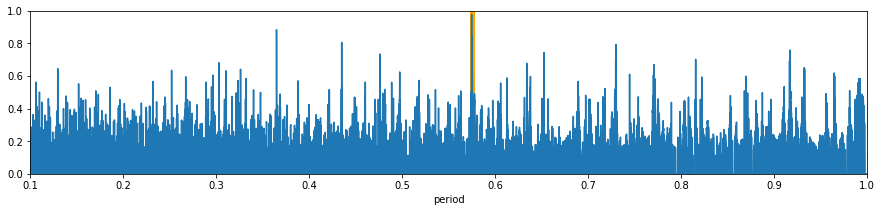

Peak signal in periodogram:  [0.57478914]  day


In [47]:
# periodogram test w/ Gaussian
periods,power = star.periodogram(p_min=0.1,p_max=1,                ## period search range
                                 method='custom',model='Gaussian', ## model selection
                                 Nterms=1, p=1,                    ## arguments for the model
                                 maxfev=100                        ## max iteration in linear regression
                                )

# plot
plot_periodogram(periods,power)

### Using your own custom function
Users can use any custom function as a model to be used in periodogram.
The model must be accompanied by initial-guess generator (```p0_func```), both of which needs to take speficic format in the argument.
See the function docstrings below.

In [5]:
### define custom functions
from numba import njit
@njit

def polynomial(x,period,params,arg1,arg2=2):
    '''
    An example custom function (model). 
    Any custom function must take the arguments (x,period,params),
    and users can add as many fixed (not fitted) arguments as needed.
    
    In this function, users can define the exponent in the polynomial
    by providing arg1 and arg2.
    '''
    mod = np.remainder(x,period)
    return params[0] + params[1]*(mod-params[3])**arg1 + params[2]*(mod-params[4])**arg2

def poly_p0(x,y,yerr,period,**kwargs):
    '''
    An example of initial-guess generator (p0_func).
    Any p0_func must take the argments (x,y,yerr,period,**kwargs).
    The output array or list must be in the same shape as "params" in the model functon.
    '''
    return [np.mean(y),1,1,period/2,period/2]

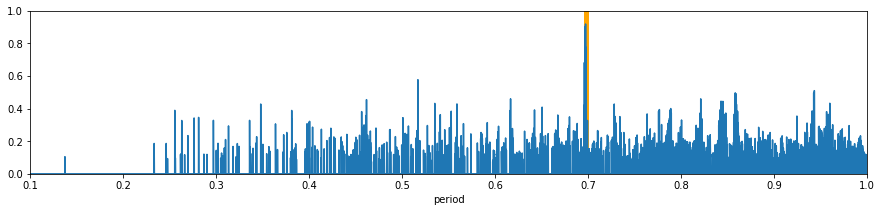

Peak signal in periodogram:  [0.69731154]  day


In [12]:
### generate periodogram with the custom function
periods,power = star.periodogram(
                    p_min=0.1, p_max=1,   ## period search between 0.1 to 1 day
                    method  ='custom',    ## for any custom function this argument needs to be given
                    model   = polynomial, ## now you can pass the function itself!
                    p0_func = poly_p0,    ## initial-guess generator function must be given as well
                    arg1    = 1,          ## users MUST specify arguments if not default is speficied
                    arg2    = 4,          ## since arg2=2 is speficified by default, this is optional
                    maxfev  = 100         ## start with small maxfev and increase later
                    )

# plot
plot_periodogram(periods,power)

## Period detection
Period detection function utilizes ```periodogram()``` and automatically detects the peak. The periodogram is then refined near the detected peak for accurate period detection. This is followed by linear regression to estimate the uncertainty of detected period.

A few things to note:
- ```photdata.get_period()``` function by default uses 5-term Fourier model.
- Users can simply run the function without any arguments to search period between 0.1-4.0 (days).
- Detected period and period error is stored in ```photdata.period``` and ```photdata.period_err```.
- This function also returns period and period error.

### Basic method

In [7]:
star.get_period(); # no argument -> 5-term Fourier, searches period between 0.1-4 day
print(star.period, star.period_err)

0.6968874975991536 2.285123956532907e-05


In [8]:
period,period_err = star.get_period(p_min=0.1,p_max=1,debug=True) # debug option enables the progress printing
print(period,period_err)

0.000s --- starting the process...
0.000s --- preparing data...
0.000s --- getting a periodogram...
0.509s --- detecting top 5 peaks...
0.510s --- preparing for finer sampling near peaks...
0.511s --- performing finer sampling near peaks...
0.916s --- period candidate:  0.6968767193610299
0.930s --- detecting aliasing...
0.930s --- alias factor:  1
0.931s --- period candidate:  0.6968767193610299
0.932s --- estimating the uncertainty...
0.947s --- period candidate:  0.6968767193610299
0.947s --- period fitted*:  0.6968786839335414
0.947s --- period error:  2.2667570909410562e-05
0.947s --- refining samples...
0.948s --- refining search width = 6.588e-04
1.315s --- period candidate:  0.6968899220719549
1.316s --- period fitted*:  0.6968946264691298
1.316s --- period error:  2.285551532900411e-05
1.316s --- * validating period error...
1.316s --- * fitted period - peak period = 4.70e-06
1.316s --- * expected deviation size = 2.29e-05
1.316s --- * period error validated
1.316s --- period 

### Advanced method
Since ```get_period()``` internally calls ```periodogram()``` function, any arguments that change the setting for ```periodogram()``` can be applied. For example, users can change the model:

In [9]:
star.get_period(p_min=0.1,p_max=1.0,method='custom',model='Gaussian')

(0.6968732145413092, 0.0001262175730778084)

Similarly, any custom model can be implemented:

In [7]:
star.get_period(p_min=0.1, p_max=1.0, 
                method='custom',
                model=polynomial, 
                p0_func=poly_p0,
                arg1 = 1,
                arg2 = 4,
                multiprocessing=False)

(0.6969893983974487, 1.8461033093986469e-09)

## Visualization

PIPS provides a tool for easy plotting with ```plot_lc()```. This function automatically uses the most recently updated period value in ```photdata``` and returns phase-folded data. There is also an easy way to overplot the best-fit model at the period using ```get_bestfit_curve()``` function. Like many other functions in ```photdata```, users can specify the model and other parameters.

In addition, ```get_epoch_offset()``` returns the time of maxima offset in phase-folded data (in units of original x-axis: not normalized to unitless phase) and enables easy offsetting / visualization of epoch.

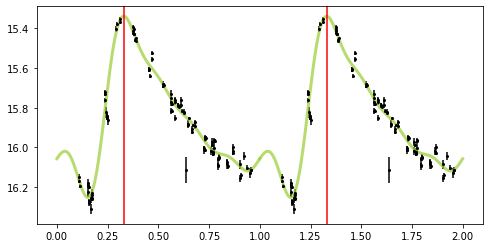

In [19]:
# detect period
star.get_period()

# phase-folded plot
star.plot_lc() # plots (x%period, y) scatter: normalized to phase
x_th,y_th = star.get_bestfit_curve()
epoch_offset = star.get_epoch_offset() # the epoch offset in the unit of [days] (not normalized to phase)

# plot
plt.plot(x_th/star.period,y_th,c='yellowgreen',lw=3,alpha=0.7)
plt.plot(x_th/star.period+1,y_th,c='yellowgreen',lw=3,alpha=0.7)
plt.axvline(epoch_offset/star.period,color='red')
plt.axvline(epoch_offset/star.period+1,color='red')

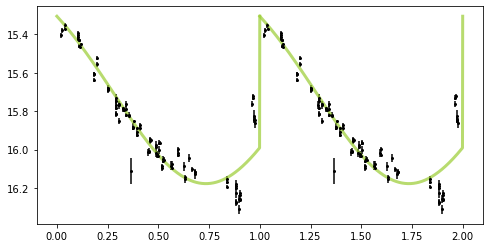

In [18]:
# get period with Gaussian model
p_Gaussian,p_err_Gaussian = star.get_period(p_min=0.1,p_max=1.0,method='custom',model='Gaussian')

# auto plot at specified period
star.plot_lc(period=p_Gaussian)
x_th,y_th = star.get_bestfit_curve(period=p_Gaussian,model='Gaussian',Nterms=1,p=1,maxfev=1000000)

# plot
plt.plot(x_th/star.period,y_th,c='yellowgreen',lw=3,alpha=0.7)
plt.plot(x_th/star.period+1,y_th,c='yellowgreen',lw=3,alpha=0.7)

## Multi-period detection
When the object is expected to have more than one period (e.g., double-mode pulsator or variable binaries), the light curve can be a superposition of periodic variation at two or more periods. PIPS can automatically generate the amplitude spectrum of multi-periodic objects.

When ```get_period_multi``` is called, it returns the detected period and amplitude of top ```N``` periods. ```amplitude_spectrum``` internally calls it and generates the amplitude spectrum. It should be noted that, however, PIPS forces the detection, even if the signal is just one of the tallest spikes in the background noise and not the real period.

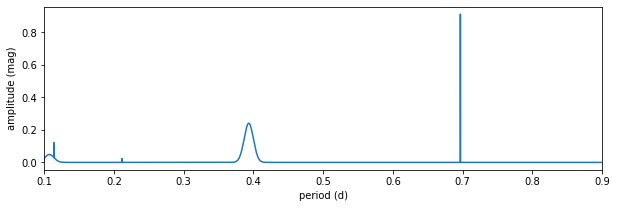

In [8]:
# multi-period detection
period,spectrum = star.amplitude_spectrum(p_min=0.1,p_max=0.9,N=10,multiprocessing=False)

plt.figure(figsize=(10,3))
plt.plot(period,spectrum)
plt.xlim(0.1,0.9)
plt.xlabel('period (d)')
plt.ylabel('amplitude (mag)')
plt.show()